In [1]:
import os
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('/kaggle/input/mobile-phone-pricing-dataset/Mobile Phone Pricing.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


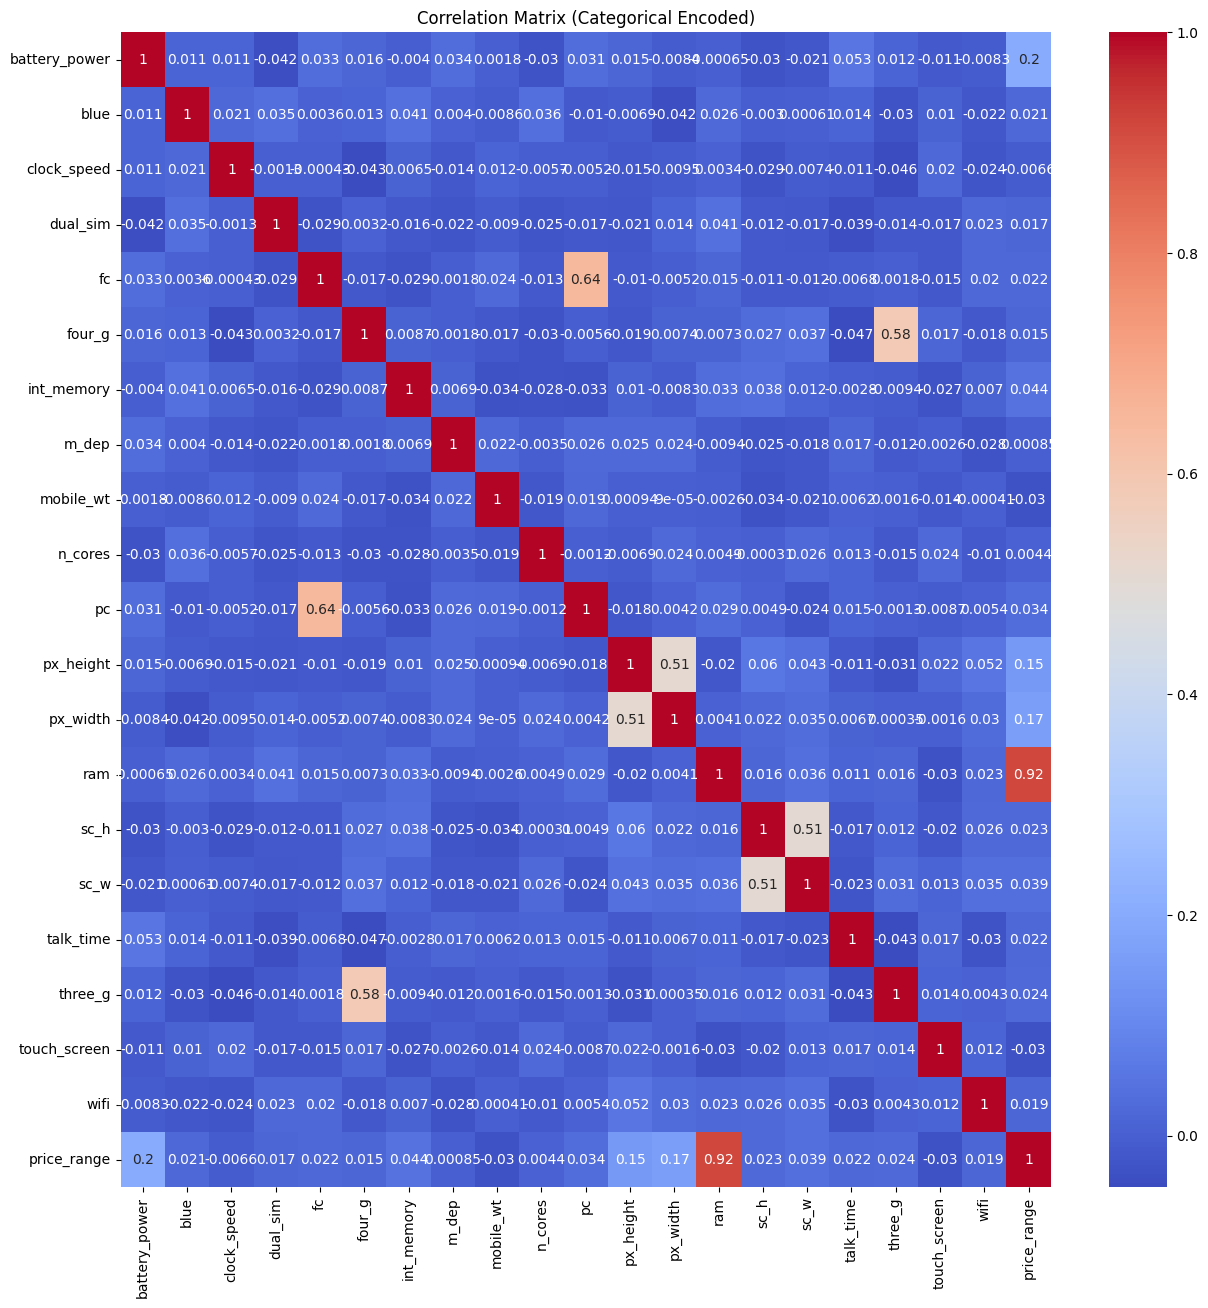

In [3]:
# Compute correlation matrix
corr = df.corr()
plt.figure(figsize=(15,15))
# Plot heatmap
sns.heatmap(corr, cmap="coolwarm",annot=True)
plt.title("Correlation Matrix (Categorical Encoded)")
plt.show()

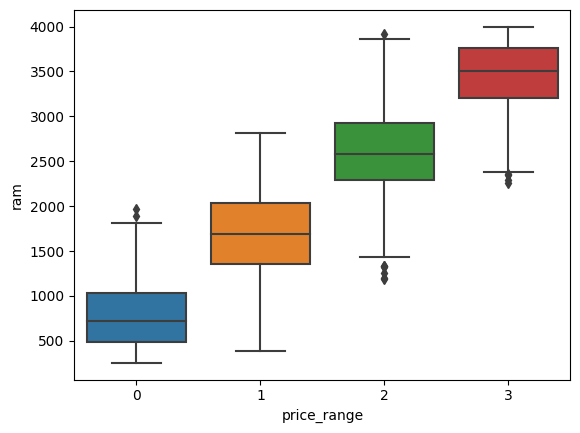

In [4]:
sns.boxplot(x='price_range',y='ram',data=df)
plt.show()

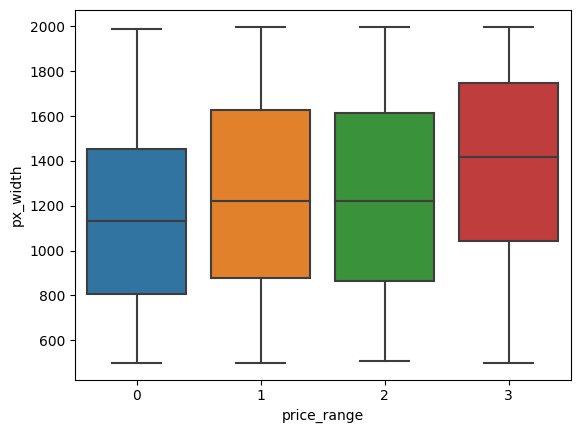

In [5]:
sns.boxplot(x='price_range',y='px_width',data=df)
plt.show()

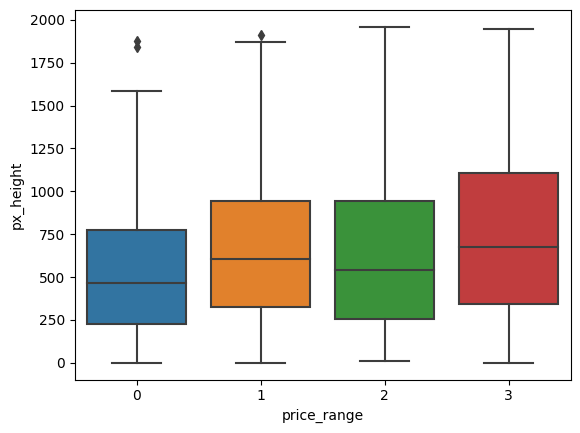

In [6]:
sns.boxplot(x='price_range',y='px_height',data=df)
plt.show()

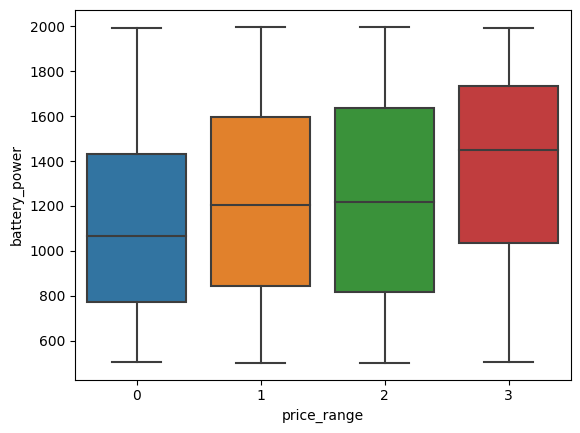

In [7]:
sns.boxplot(x='price_range',y='battery_power',data=df)
plt.show()

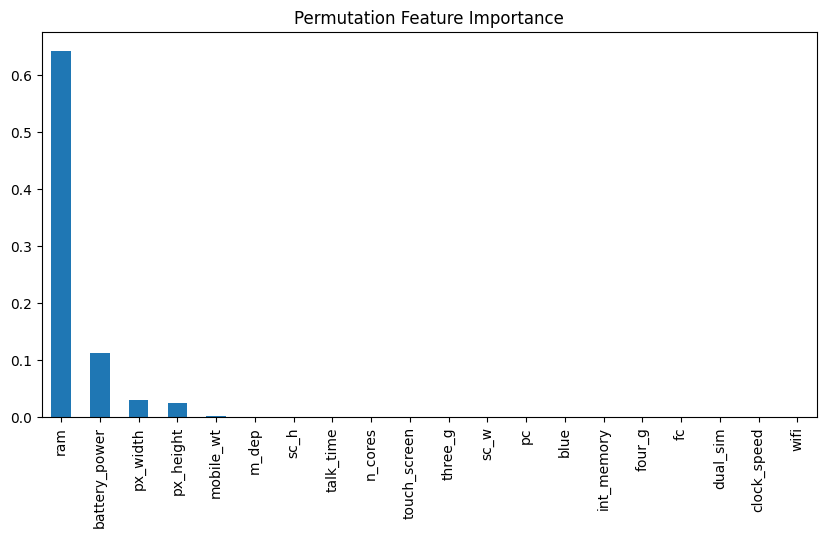

In [8]:
X=df.drop('price_range',axis=1)
y=df['price_range']

model = RandomForestClassifier()
model.fit(X,y)

result = permutation_importance(model, X, y, n_repeats=20, random_state=42)

# Convert to series
perm_importance = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

# Plot
perm_importance.plot(kind="bar", figsize=(10, 5))
plt.title("Permutation Feature Importance")
plt.show()

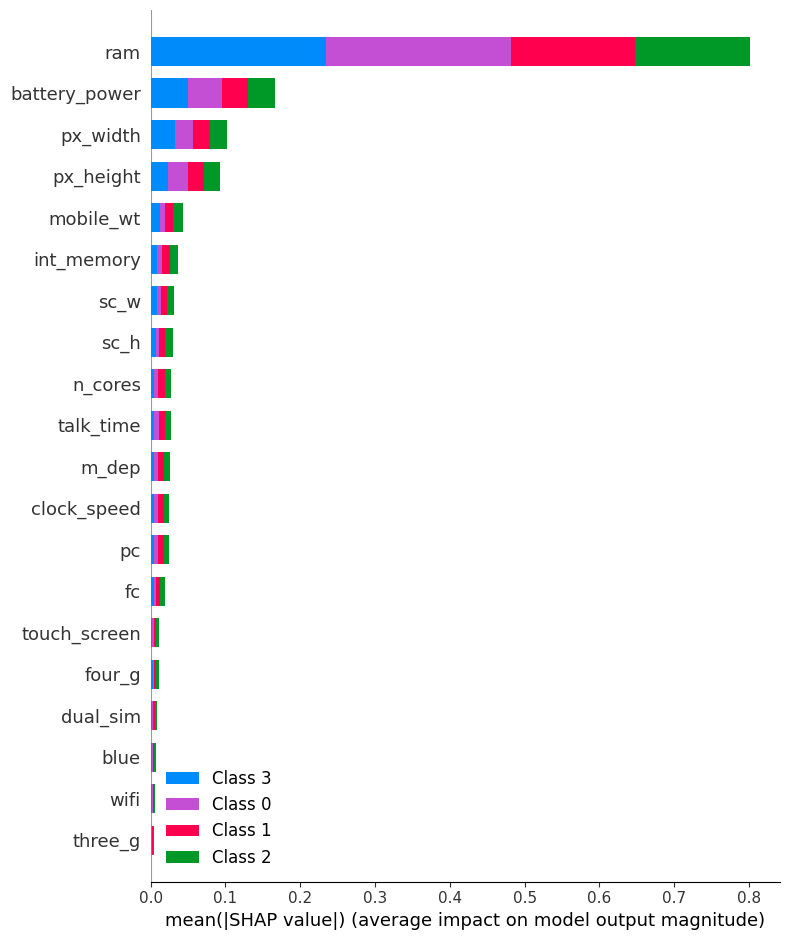

In [9]:
# For tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X)

In [10]:
X=df.drop('price_range',axis=1)
y=df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((1600, 20), (400, 20))

In [11]:
model1 = RandomForestClassifier()
scores = cross_val_score(model1, X_train, y_train, cv=3)

print("CV Scores:", scores)
print("Average CV Score:", scores.mean())

model1.fit(X_train, y_train)
test_accuracy = model1.score(X_test, y_test)
print("Final model accuracy on test set:", test_accuracy)


CV Scores: [0.86142322 0.88180113 0.81988743]
Average CV Score: 0.8543705921069581
Final model accuracy on test set: 0.885


In [12]:
X=df[['ram','battery_power','px_width','px_height']]
y=df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((1600, 4), (400, 4))

In [13]:
model2 = RandomForestClassifier()
scores = cross_val_score(model2, X_train, y_train, cv=3)

print("CV Scores:", scores)
print("Average CV Score:", scores.mean())

model2.fit(X_train, y_train)
test_accuracy = model2.score(X_test, y_test)

print("Final model accuracy on test set:", test_accuracy)

CV Scores: [0.91573034 0.90619137 0.87992495]
Average CV Score: 0.9006155532601134
Final model accuracy on test set: 0.935


In [14]:
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       105
           1       0.91      0.97      0.94        91
           2       0.89      0.89      0.89        92
           3       0.95      0.92      0.94       112

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400



In [15]:
model3 = XGBClassifier(use_label_encoder=False,)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2,0.5,1],
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=model3,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',  
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)


best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
Best cross-validated accuracy: 0.911871417763443
Test accuracy: 0.9275


In [16]:
y_pred = best_model.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       105
           1       0.88      0.97      0.92        91
           2       0.91      0.85      0.88        92
           3       0.94      0.94      0.94       112

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400

